# CS 483 Question 2

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=bac6c2d8c0f8ca2cbeb8387ce3af8c431e6d45a1cd0dd23a2c2e47740df4bf23
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 39.6 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# get data.txt and c1.txt and c2.txt
id_data='1E-voIV2ctU4Brw022Na8RHVVRGOoNkO1'
downloaded_data = drive.CreateFile({'id': id_data})
downloaded_data.GetContentFile('data.txt')

id_c1='1yXNlZWMqUcAwDScBrkFChOHJwR1FZXmI'
downloaded_c1 = drive.CreateFile({'id': id_c1})
downloaded_c1.GetContentFile('c1.txt')

id_c2='1vfovle9DgaeK0LnbQTH0j7kRaJjsvLtb'
downloaded_c2 = drive.CreateFile({'id': id_c2})
downloaded_c2.GetContentFile('c2.txt')

## Iterative K means with Euclidian distance

In [6]:
ITERATIONS = 20

def euclidian_distance(x, y):
  return np.sqrt(np.sum((x-y)**2))

def manhattan_distance(x, y):
  return np.sum(np.abs(x-y))

In [7]:
X = spark.read.text('data.txt').rdd.map(lambda r: r[0]).map(lambda x: np.array([float(i) for i in x.split(' ')]))

with open('c1.txt', 'r') as f:
  c1 = [(i, v) for i, v in enumerate(np.array([np.array([float(i) for i in line.split(' ')]) for line in f.readlines()]))]

with open('c2.txt', 'r') as f:
  c2 = [(i, v) for i, v in enumerate(np.array([np.array([float(i) for i in line.split(' ')]) for line in f.readlines()]))]


In [8]:
def find_nearest_centroid(point, centroids, distance_metric):
  min_distance = float('inf')
  min_centroid = None
  for centroid in centroids:
    distance = distance_metric(point, centroid[1])
    if distance < min_distance:
      min_distance = distance
      min_centroid = centroid[0]
  return (min_centroid, point, min_distance)

def compute_centroid(points):
  points = np.array(points)
  return np.add.reduce(points) / len(points)

In [9]:
new_centroids = c1
costs_c1_euclidian = []

for i in range(ITERATIONS):
  print(f'Iteration {i+1}')
  nearest_centroids = X.map(lambda x: find_nearest_centroid(x, new_centroids, euclidian_distance))
  cost = nearest_centroids.map(lambda x: x[2] ** 2).sum()
  print(f'Cost: {cost}')
  costs_c1_euclidian.append(cost)
  new_centroids = nearest_centroids.map(lambda x: (x[0], x[1])).groupByKey().mapValues(lambda x: compute_centroid(list(x))).collect()

Iteration 1
Cost: 623660345.3064235
Iteration 2
Cost: 509862908.29754597
Iteration 3
Cost: 485480681.8720084
Iteration 4
Cost: 463997011.6850107
Iteration 5
Cost: 460969266.57299405
Iteration 6
Cost: 460537847.98277014
Iteration 7
Cost: 460313099.65354246
Iteration 8
Cost: 460003523.88940686
Iteration 9
Cost: 459570539.3177354
Iteration 10
Cost: 459021103.34229016
Iteration 11
Cost: 458490656.1919808
Iteration 12
Cost: 457944232.5879742
Iteration 13
Cost: 457558005.1986796
Iteration 14
Cost: 457290136.3523032
Iteration 15
Cost: 457050555.0595639
Iteration 16
Cost: 456892235.61535746
Iteration 17
Cost: 456703630.7370357
Iteration 18
Cost: 456404203.0189769
Iteration 19
Cost: 456177800.54199505
Iteration 20
Cost: 455986871.02734846


In [10]:
new_centroids = c2
costs_c2_euclidian = []
for i in range(ITERATIONS):
  print(f'Iteration {i+1}')
  nearest_centroids = X.map(lambda x: find_nearest_centroid(x, new_centroids, euclidian_distance))
  cost = nearest_centroids.map(lambda x: x[2] ** 2).sum()
  print(f'Cost: {cost}')
  costs_c2_euclidian.append(cost)
  new_centroids = nearest_centroids.map(lambda x: (x[0], x[1])).groupByKey().mapValues(lambda x: compute_centroid(list(x))).collect()

Iteration 1
Cost: 438747790.027918
Iteration 2
Cost: 249803933.62600294
Iteration 3
Cost: 194494814.406314
Iteration 4
Cost: 169804841.45154336
Iteration 5
Cost: 156295748.806276
Iteration 6
Cost: 149094208.10896608
Iteration 7
Cost: 142508531.61961588
Iteration 8
Cost: 132303869.40653005
Iteration 9
Cost: 117170969.8371908
Iteration 10
Cost: 108547377.17857017
Iteration 11
Cost: 102237203.31799614
Iteration 12
Cost: 98278015.74975717
Iteration 13
Cost: 95630226.12177445
Iteration 14
Cost: 93793314.05119292
Iteration 15
Cost: 92377131.96821108
Iteration 16
Cost: 91541606.25423913
Iteration 17
Cost: 91045573.83042422
Iteration 18
Cost: 90752240.10140836
Iteration 19
Cost: 90470170.18122767
Iteration 20
Cost: 90216416.17563146


## Iterative K means with Manhattan distance

In [11]:
new_centroids = c1
costs_c1_manhattan = []
for i in range(ITERATIONS):
  print(f'Iteration {i+1}')
  nearest_centroids = X.map(lambda x: find_nearest_centroid(x, new_centroids, manhattan_distance))
  cost = nearest_centroids.map(lambda x: x[2]).sum()
  print(f'Cost: {cost}')
  costs_c1_manhattan.append(cost)
  new_centroids = nearest_centroids.map(lambda x: (x[0], x[1])).groupByKey().mapValues(lambda x: compute_centroid(list(x))).collect()

Iteration 1
Cost: 550117.1420000045
Iteration 2
Cost: 464829.26840394654
Iteration 3
Cost: 470934.15384668263
Iteration 4
Cost: 483874.81628509297
Iteration 5
Cost: 489234.2347883483
Iteration 6
Cost: 487664.6926267901
Iteration 7
Cost: 483718.66592851654
Iteration 8
Cost: 475337.94763305597
Iteration 9
Cost: 474871.9665496577
Iteration 10
Cost: 457244.78974174923
Iteration 11
Cost: 447493.195604051
Iteration 12
Cost: 450891.8358047716
Iteration 13
Cost: 451232.5774756949
Iteration 14
Cost: 451860.12588546367
Iteration 15
Cost: 451567.2235891512
Iteration 16
Cost: 452710.0520999444
Iteration 17
Cost: 453078.22696184984
Iteration 18
Cost: 450646.13556209754
Iteration 19
Cost: 450419.97011343326
Iteration 20
Cost: 449009.59037188475


In [12]:
new_centroids = c2
costs_c2_manhattan = []
for i in range(ITERATIONS):
  print(f'Iteration {i+1}')
  nearest_centroids = X.map(lambda x: find_nearest_centroid(x, new_centroids, manhattan_distance))
  cost = nearest_centroids.map(lambda x: x[2]).sum()
  print(f'Cost: {cost}')
  costs_c2_manhattan.append(cost)
  new_centroids = nearest_centroids.map(lambda x: (x[0], x[1])).groupByKey().mapValues(lambda x: compute_centroid(list(x))).collect()

Iteration 1
Cost: 1433739.3099999938
Iteration 2
Cost: 1084488.7769648738
Iteration 3
Cost: 973431.7146620394
Iteration 4
Cost: 895934.5925630673
Iteration 5
Cost: 865128.3352940796
Iteration 6
Cost: 845846.6470313473
Iteration 7
Cost: 827219.5827561237
Iteration 8
Cost: 803590.3456011107
Iteration 9
Cost: 756039.5172761244
Iteration 10
Cost: 717332.9025432297
Iteration 11
Cost: 694587.9252526843
Iteration 12
Cost: 684444.5019967926
Iteration 13
Cost: 674574.7475478566
Iteration 14
Cost: 667409.469916026
Iteration 15
Cost: 663556.6278214998
Iteration 16
Cost: 660162.777228758
Iteration 17
Cost: 656041.3222947085
Iteration 18
Cost: 653036.7540731638
Iteration 19
Cost: 651112.4262522653
Iteration 20
Cost: 649689.0131843556


## Plots

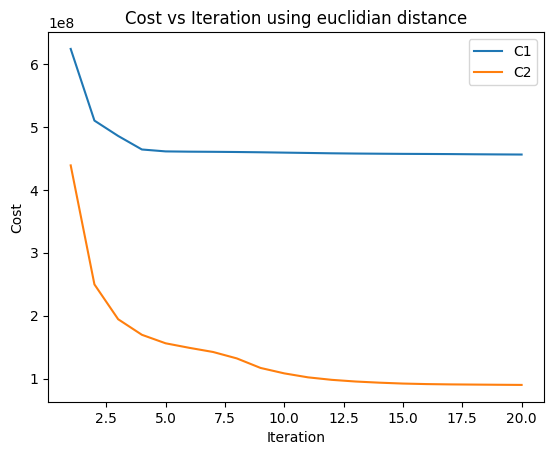

In [13]:
timestamps = [i for i in range(1, ITERATIONS+1)]
plt.plot(timestamps, costs_c1_euclidian, label='C1')
plt.plot(timestamps, costs_c2_euclidian, label='C2')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs Iteration using euclidian distance')
plt.legend()

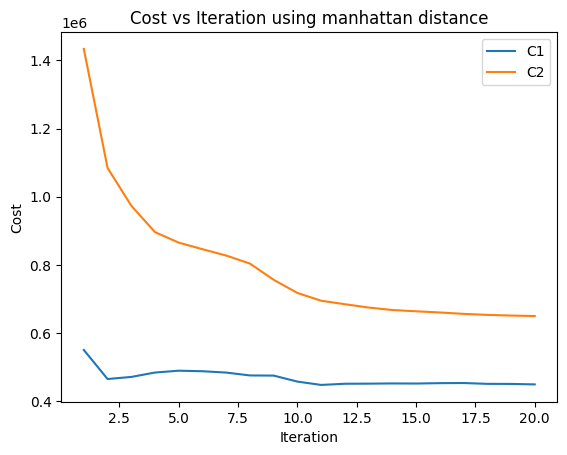

In [14]:
timestamps = [i for i in range(1, ITERATIONS+1)]
plt.plot(timestamps, costs_c1_manhattan, label='C1')
plt.plot(timestamps, costs_c2_manhattan, label='C2')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs Iteration using manhattan distance')
plt.legend()

## % cost change

In [15]:
((costs_c1_euclidian[0] - costs_c1_euclidian[9]) / costs_c1_euclidian[0]) * 100

26.398863292044172

In [16]:
((costs_c2_euclidian[0] - costs_c2_euclidian[9]) / costs_c2_euclidian[0]) * 100

75.25973243724756

In [17]:
((costs_c1_manhattan[0] - costs_c1_manhattan[9]) / costs_c1_manhattan[0]) * 100

16.882286547299508

In [18]:
((costs_c2_manhattan[0] - costs_c2_manhattan[9]) / costs_c2_manhattan[0]) * 100

49.96768955555576